Is it worth gathering data and taking measurements before making decisions? Obviously yes! However, decisions can be composed of many variables with varying degrees of importance and uncertainty. Which should you measure? How much should you spend to do so?

In this post, we'll consider an [existing model](https://www.getguesstimate.com/models/3206) of a flower shop business. It's not a perfect model (we'll cover that later) but it's simple and useful enough for this example. We'd like to run the business if we expect it to be profitable, and there are a few factors which go into that. Using Python, we'll determine which of those factors we should research, which can be ignored, and how much we would be willing to spend if we could buy perfect information.

# Modeling with estimates

Throughout this exersize, we'll be using distributions parametrized using 90% confidence intervals in the same way Guesstimate does. As discussed in my [post] **TODO LINK** on the subject, this is an intuitive way to convert estimations from human experts framed in terms such as "top 5%, bottom 5%" into useful models. The code below lets us do that.

In [1]:
from scipy.stats import poisson, lognorm, norm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

def norm_from_percentiles(x1, x2, p1=0.05, p2=0.95):
    """ Return a normal distribution defined by its 90% Confidence Interval """
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)

    mean = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    scale = (x2 - x1) / (p2ppf - p1ppf)

    return norm(loc=mean, scale=scale)

def lognorm_from_percentiles(x1, x2, p1=0.05, p2=0.95):
    """ Return a log-normal distribution defined by its 90% Confidence Interval """
    x1 = np.log(x1)
    x2 = np.log(x2)
    p1ppf = norm.ppf(p1)
    p2ppf = norm.ppf(p2)
    
    scale = (x2 - x1) / (p2ppf - p1ppf)
    mean = ((x1 * p2ppf) - (x2 * p1ppf)) / (p2ppf - p1ppf)
    
    return lognorm(scale, scale=np.exp(mean))

def histogram(dist, name, density=True, bins=50, dollars=False):
    """ Plot the histogram of samples from a distribution """
    if hasattr(dist, 'rvs'):
        dist = dist.rvs(50000)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.hist(dist, density=density, bins=bins, )
    plt.title(f"Distribution of {name}")
    plt.xlabel(name)
    plt.ylabel("Probability density")
    if dollars:
        formatter = ticker.StrMethodFormatter('${x:,.0f}')
        ax.xaxis.set_major_formatter(formatter)

# The Flower shop

We estimate that roughly 20 **customers** will enter the flower shop per day. Each of them will **spend** between \\$10 and \\$90. They'll buy a variety of products which will be taxed differently, so the overall mix of **VAT** will vary between 7% and 19%.

These are our uncertain variables. For the sake of simplicity, the model sets some things as known, such as the number of staff (2) the hourly wage (\\$12), working hours per day (8).

In [2]:
# Customer behaviour (not known)

customers_per_day = poisson(20)
spend_per_customer = norm_from_percentiles(10, 90)
vat_mix = lognorm_from_percentiles(7, 19)

# Labor costs (all known)

number_of_staff = 2
hourly_wage = 12
working_hours_per_day = 8
insurance_multiplier = 1.19325
labor_cost_per_day = (number_of_staff * hourly_wage * working_hours_per_day) * insurance_multiplier

# Business operations (all known)

income_tax = 1.42
cost_of_goods_percent = 0.3
working_days_per_year = 360

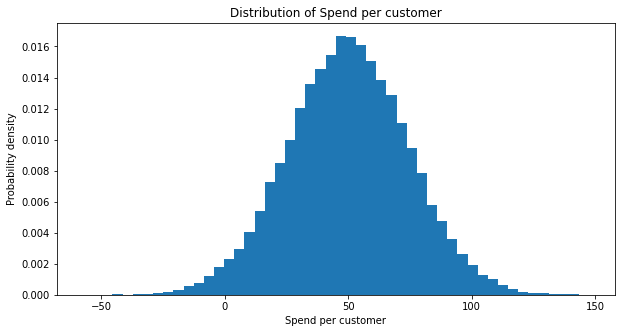

In [3]:
histogram(spend_per_customer, "Spend per customer")

The model below returns the net income (profit) for a year of operation of the business. If we provide the model with distributions for each variable, we can model a variety of outcomes

In [4]:
def model(customers_per_day, spend_per_customer, vat_mix):
    net_expenditures_for_goods = spend_per_customer * cost_of_goods_percent
    
    revenue = customers_per_day * (spend_per_customer - net_expenditures_for_goods)

    earnings_before_taxes = revenue - labor_cost_per_day
    
    vat_multiplier = (1.0 / (1.0 + vat_mix/100))
    
    income_before_taxes = earnings_before_taxes * vat_multiplier
    
    income_after_income_tax = income_before_taxes / income_tax
    
    income_per_year = income_after_income_tax * working_days_per_year
    
    return income_per_year

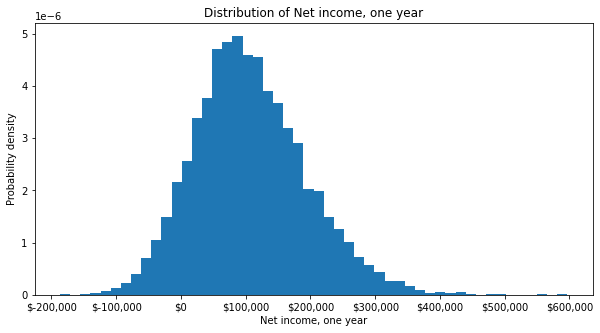

In [5]:
results = model(customers_per_day.rvs(10000), spend_per_customer.rvs(10000), vat_mix.rvs(10000))

histogram(results, "Net income, one year", dollars=True);

In [118]:
print(f"Overall average income: ${results.mean():,.0f}")
print()
print(f"Chance of profit: {(results > 0).mean():.1%}")
print(f"Chance of loss: {(results < 0).mean():.1%}")


# print(f"Average profit (in profitable simulations): ${(results[results > 0]).mean():,.0f}")
# print(f"Expected profit (across all simulations): ${(results.clip(min=0)).mean():,.0f}")
# print()

# print(f"Average loss (in losing simulations): ${(results[results < 0]).mean():,.0f}")

# print(f"Expected loss (across all simulations): ${(results.clip(max=0)).mean():,.0f}")

Overall average income: $106,904

Chance of profit: 90.4%
Chance of loss: 9.6%
Average profit (in profitable simulations): $121,642
Average loss (in losing simulations): $-32,361


There's a 90.4% chance we'll make more than \\$0 and on average we'll make just over \\$100k, but we could lose money, and even losing \\$100k isn't out of the question. Would you run this business?

Most people won't have \\$100k to lose in the worst case scenario, but if we assume that we're weighing this option versus others, or that we're wealthy entrepeneurs with enough money to make multiple bets like this, the math checks out - we should take whichever actions have the highest expected return, and with enough bets, we'll make a profit.

Thus, since average profit is greater than average loss in this example, our current _default decision_ should be to run the business. That has some implications:

1. Information which shows us we'll be more profitable than we expected is not useful, because it won't change our decision. It would just be a nice surprise!
2. Information which shows us we'll be less profitable than we expected **may be** be useful, if we learn that the business is actually unlikely to be profitable.

# Buying perfect information

In [111]:
print(f"Mean loss in losing simulations: ${(results[results < 0]).mean():,.0f}")
print(f"Expected Loss (mean loss across all simulations): ${(results.clip(max=0)).mean():,.0f}")

Mean loss in losing simulations: $-32,361
Expected Loss (mean loss across all simulations): $-3,097


We've decided we'll probably run the business. On average, when we're wrong, we lose \\$32k, but since our current estimate puts that at 9.6\% liklihood, we say that our "Expected Loss" is $3,097.

That's the maximum you should be willing to pay for _perfect information_ on whether the business will succeed. If you pay less than that, great; if you pay more, you're spending more than you reasonably expect to lose.

Note that this number doesn't take into account how much we stand to make - even if the average profit in winning scenarios was \\$1 million, we still ought to pay up to $3,097 to completely reduce our uncertainty.

That's what the book says, and to be honest I wasn't completely convinced, so I set up a simulation to prove it to myself.

## Buying the result of a coin flip

I offer to play this game with as many times as you'd like: Flip a coin; Heads, you win \\$50, Tails, you loose \\$1000. I'm pretty sure you would not play this game; that is your *default decision*. Given that decision, if I flip the coin anyway and it lands on Heads, you lose out on \\$50. Losing out on a potential reward is Opportunity Loss, and since you expect a 50\% chance of Heads, your Expected Opportunity Loss is \\$25.

If I offer the result in of the coin-flip in advance - for a price - then the most you should be willing to pay is \\$25, which brings the exepected value of the game to \\$0. When you buy information, the game looks like this:

|       | Chance |  Cost of information | Action  |  Reward |  Net Profit  |
|-------|--------|----------------------|---------|---------|--------------|
| Heads |  50\%  | \\$25                |  Play   | \\$50   |    \\$25     |
| Tails |  50\%  | \\$25                |  Pass   | \\$0    |   -\\$25     |

If you pay more than \\$25, you won't win enough to cover the information price. If you can get the information for less than \\$25 then great, you stand to make a profit!

Notice that the \\$1000 doesn't come into play here at all - because you've already decided not to play

## Buying the result of a coin flip

I set up a game where a coin is flipped many times. Players win \\$200 on heads and lose \\$100 on tails. The expected value of one coin flip is $ \frac{\$200}{2} - \frac{$100}{2} = \$50 $, so in the long run, it's worth playing and agents will play this game by default.

Given that you've decided to play this game, the Expected Loss is \\$100 * 50\% = \\$50.

Each flip, players are offered to buy the outcome of the game for a random price, and then given the choice to back out. Players who buy the information and then learn that they'll lose will back out

A number of agents play the game, and each agent is willing to pay up to a certain amount to know the outcome - for example, one agent might only pay up to \\$10, another might pay as much as \\$100.

Which agent does the best?

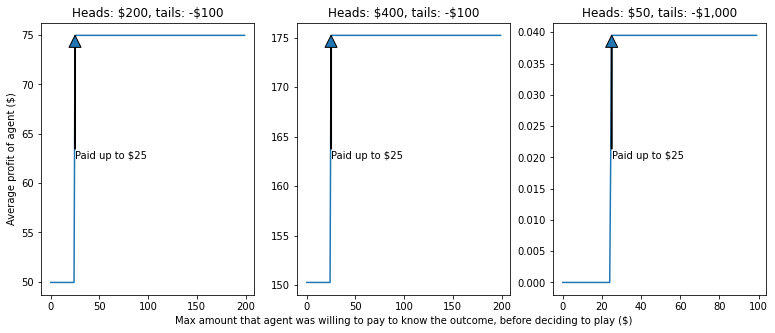

In [125]:
def game(ax, win_amount, lose_amount, N=200000):
    
    # A coin is flipped N times
    coin = np.random.randint(2, size=N)
    
    # The result of the game is win_amount on heads, and lose_amount on tails
    result = ((coin == 1) * win_amount - (coin == 0) * lose_amount)
    
    # With no information, you should play this game if win_amount > lose_amount
    default = win_amount > lose_amount
    
    # Each game I will offer the outcome of the game for a random amount of money
    # Up to the maximum amount M which can be won or lost.
    max_offer = min(win_amount, lose_amount) * 2
    offer = 25 #np.random.randint(max_offer/4, size=N)
    
    # M agents play the game, numbered from 0 to M
    agents = np.arange(0, max_offer)
    
    # Agents buy the information if they are willing to pay more (or exactly) my offer.
    agent_buys_info = np.broadcast_to(agents, (N, len(agents))).T >= offer

    # Agents which bought information play the game if they know they'll win
    # Agents which did not buy information play the default option
    plays = (agent_buys_info & coin) | (~agent_buys_info & default)
    
    # An agent's profit is the result of playing, minus whatever they spent on information.
    revenue = plays * result
    spent_on_information = agent_buys_info * offer
    profit = revenue - spent_on_information
    
    # Sum over all N games fo reach agent, and plot the result    
    all_profits = profit.mean(axis=1)
    
    ax.plot(all_profits)
    
    winner = np.argmax(all_profits)
    ax.annotate(
        f"Paid up to ${winner}",
        [winner, all_profits.max()],
        xytext=[winner, (all_profits.max() + all_profits.min())/2],
        arrowprops=dict(width=1)
    )
    ax.set_title(f"Heads: \${win_amount:,}, tails: -\${lose_amount:,}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))
game(ax1, win_amount=200, lose_amount=100)
game(ax2, win_amount=400, lose_amount=100)
game(ax3, win_amount=50, lose_amount=1000)

ax2.set_xlabel("Max amount that agent was willing to pay to know the outcome, before deciding to play ($)")
ax1.set_ylabel("Average profit of agent ($)");

The charts above show the mean profit (y axis) for a variety of agents with increasing budgets for information (x axis).

The first game has the parameters I specified above, and (allowing some error for randomness) the most successful agent was the one willing to pay up to the Expected Loss in order to know the outcome. In the second game I offer twice as much for a win, but the same agent wins again. Agents willing to pay more overpaid, agents not willing to pay so much missed out on chances to win.

The third game is a much riskier game, where I offer \\$50 for a win and take \\$1000 for a loss. Since agents _decline_ by default, they miss out on a 50% chance of \\$50 - this is Opportunity Loss. The most successful agent in this game paid up to the Expected Opportunity Loss (\\$25) to learn whether they should switch to playing. Agents not willing to pay that much tended to just not play, and so - for example - the cheapest agent spent nothing and made nothing.

# Which variable should we measure?

In [ ]:
0
-25 25
0 0
-25 25
0 0

In [130]:
(49/50)*50

49.0

In [131]:
(1/50)*1000

20.0







This is the question tackled by Chapter 6 of the book [How To Measure Anything](https://www.howtomeasureanything.com/3rd-edition/) by Douglas W. Hubbard. Hubbard describes the following process for making decisions:

1. Model the impact of your decision on something measurable, e.g. profit
2. Provide initial estimates for the parameters of the model
3. **Compute the value of measuring each variable of the model**
4. Measure the most important variables, then go back to (3) until uncertainty has been sufficiently reduced.
5. Make a decision

The book provides a detailed example for the case where your decision is based on a single variable, but unfortunately, does 